# Bayesian estimation for Poisson with Gamma prior

This notebook follows parts (a)–(i) of the exercise for a Poisson sample with true $\theta=2$ and prior $\Gamma(3,1)$ (shape-rate parameterization).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, poisson, norm

np.random.seed(7)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

## Setup

We use a Gamma prior with shape $\alpha_0=3$ and rate $\beta_0=1$. For a Poisson sample $X_1,\dots,X_n \sim \text{Pois}(\theta)$, the posterior is

$$\theta \mid x_{1:n} \sim \Gamma\left(\alpha_0 + \sum_{i=1}^n x_i,\ \beta_0 + n\right).$$

Prior mean and standard deviation:

$$\mathbb{E}[\theta]=\alpha_0/\beta_0,\quad \text{SD}(\theta)=\sqrt{\alpha_0}/\beta_0.$$

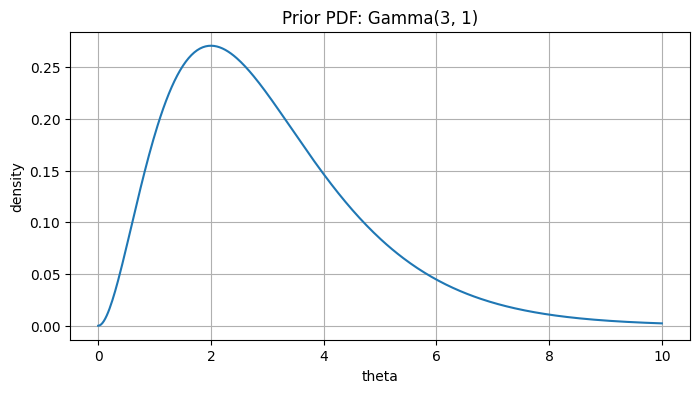

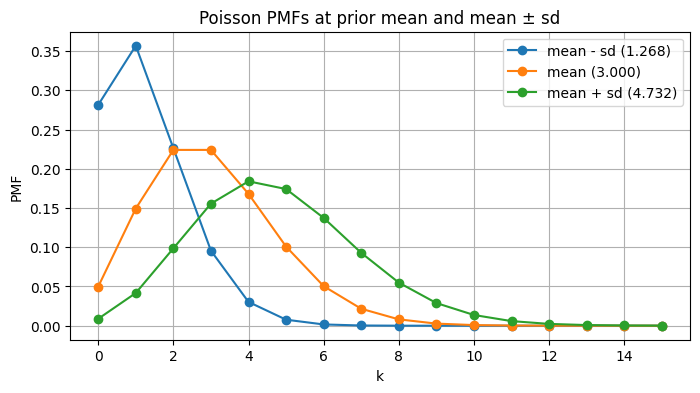

In [9]:
# (a) Prior PDF
alpha0, beta0 = 3.0, 1.0
prior_mean = alpha0 / beta0
prior_sd = np.sqrt(alpha0) / beta0

x = np.linspace(0, 10, 400)
plt.plot(x, gamma.pdf(x, a=alpha0, scale=1 / beta0))
plt.title("Prior PDF: Gamma(3, 1)")
plt.xlabel("theta")
plt.ylabel("density")
plt.show()

# (b) Poisson PMFs at mean, mean ± sd
lam_values = [prior_mean - prior_sd, prior_mean, prior_mean + prior_sd]
labels = ["mean - sd", "mean", "mean + sd"]

k = np.arange(0, 16)
for lam, lab in zip(lam_values, labels):
    plt.plot(k, poisson.pmf(k, mu=lam), marker="o", linestyle="-", label=f"{lab} ({lam:.3f})")

plt.title("Poisson PMFs at prior mean and mean ± sd")
plt.xlabel("k")
plt.ylabel("PMF")
plt.legend()
plt.show()

In [16]:
# (c) Simulate data and compute sequential posteriors
n = 500
true_theta = 2.0

data = np.random.poisson(lam=true_theta, size=n)

cum_sum = np.cumsum(data)
idx = np.arange(1, n + 1)

alpha_post = alpha0 + cum_sum
beta_post = beta0 + idx

post_mean = alpha_post / beta_post
post_sd = np.sqrt(alpha_post) / beta_post

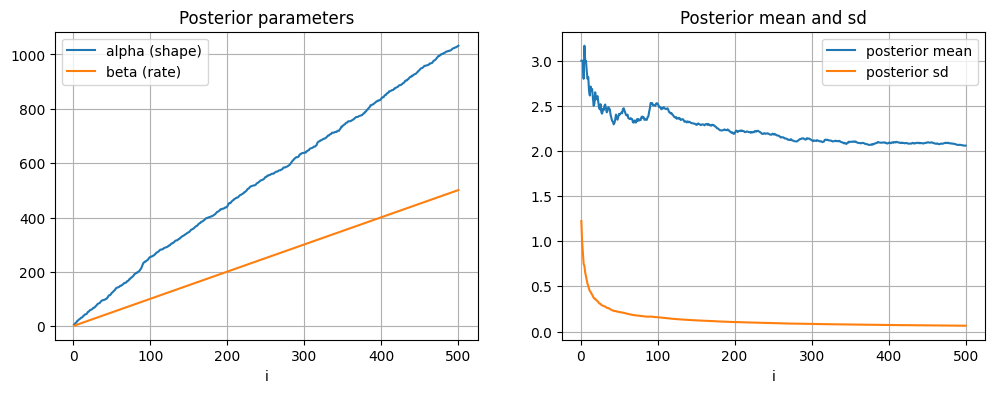

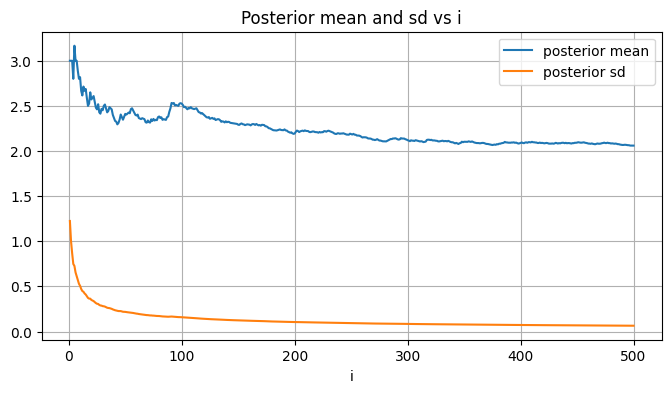

In [22]:
# (c) Plot posterior parameters and posterior mean/sd
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(idx, alpha_post, label="alpha (shape)")
ax[0].plot(idx, beta_post, label="beta (rate)")
ax[0].set_title("Posterior parameters")
ax[0].set_xlabel("i")
ax[0].legend()

ax[1].plot(idx, post_mean, label="posterior mean")
ax[1].plot(idx, post_sd, label="posterior sd")
ax[1].set_title("Posterior mean and sd")
ax[1].set_xlabel("i")
ax[1].legend()
plt.show()

# (d) Plot mean and sd again (separate figure for clarity)
plt.plot(idx, post_mean, label="posterior mean")
plt.plot(idx, post_sd, label="posterior sd")
plt.title("Posterior mean and sd vs i")
plt.xlabel("i")
plt.legend()
plt.show()

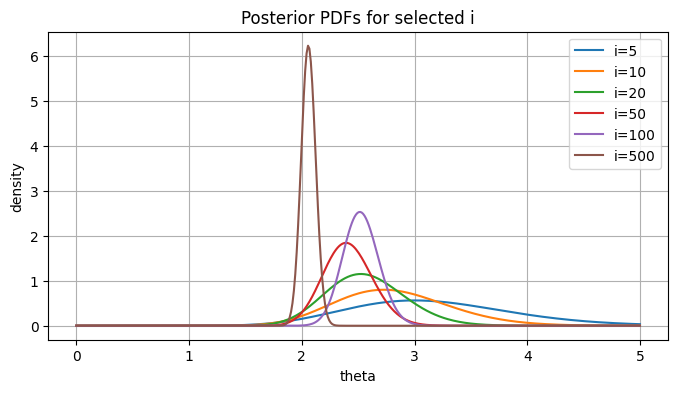

In [27]:
# (e) Plot posteriors for selected i
selected = [5, 10, 20, 50, 100, 500]
xs = np.linspace(0, 5, 400)

for i in selected:
    a_i = alpha_post[i - 1]
    b_i = beta_post[i - 1]
    plt.plot(xs, gamma.pdf(xs, a=a_i, scale=1 / b_i), label=f"i={i}")

plt.title("Posterior PDFs for selected i")
plt.xlabel("theta")
plt.ylabel("density")
plt.legend()
plt.show()

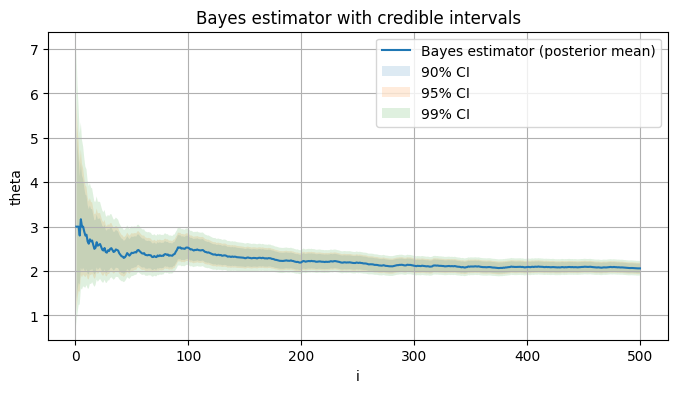

In [31]:
# (f) Bayes estimator (quadratic loss) and credible intervals
bayes_est = post_mean

levels = [0.90, 0.95, 0.99]
intervals = {}
for level in levels:
    low_q = (1 - level) / 2
    high_q = 1 - low_q
    lower = gamma.ppf(low_q, a=alpha_post, scale=1 / beta_post)
    upper = gamma.ppf(high_q, a=alpha_post, scale=1 / beta_post)
    intervals[level] = (lower, upper)

plt.plot(idx, bayes_est, label="Bayes estimator (posterior mean)")
for level in levels:
    lower, upper = intervals[level]
    plt.fill_between(idx, lower, upper, alpha=0.15, label=f"{int(level*100)}% CI")

plt.title("Bayes estimator with credible intervals")
plt.xlabel("i")
plt.ylabel("theta")
plt.legend()
plt.show()

## (g) MLE, standard error, and limiting distribution

For a Poisson sample, the log-likelihood is

$$\ell(\theta)=\sum_{i=1}^n \left(x_i\log\theta-\theta-\log(x_i!)\right).$$

Setting $\partial \ell/\partial \theta = 0$ gives

$$\hat\theta_{\text{MLE}}=\bar X = \frac{1}{n}\sum_{i=1}^n x_i.$$

The Fisher information for one observation is $I(\theta)=1/\theta$, so

$$\text{Var}(\hat\theta_{\text{MLE}}) \approx \frac{\theta}{n},\quad \text{SE}(\hat\theta_{\text{MLE}}) \approx \sqrt{\theta/n}.$$

By the CLT / asymptotic normality,

$$\sqrt{n}(\hat\theta_{\text{MLE}}-\theta) \xrightarrow{d} N(0,\theta).$$

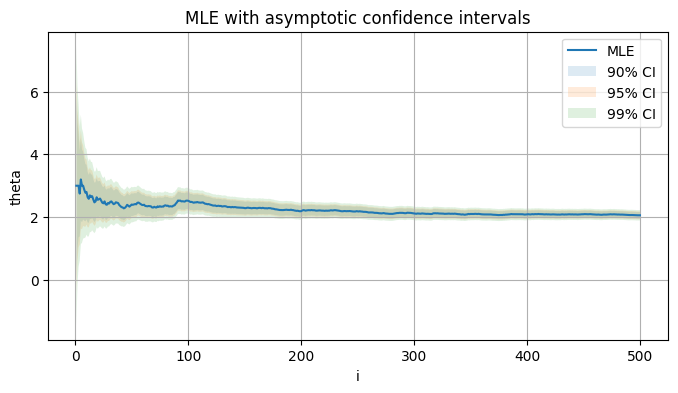

In [34]:
# (h) Sequential MLE and confidence intervals
mle = cum_sum / idx
mle_se = np.sqrt(np.maximum(mle, 0) / idx)

mle_intervals = {}
for level in levels:
    z = norm.ppf(1 - (1 - level) / 2)
    lower = mle - z * mle_se
    upper = mle + z * mle_se
    mle_intervals[level] = (lower, upper)

plt.plot(idx, mle, label="MLE")
for level in levels:
    lower, upper = mle_intervals[level]
    plt.fill_between(idx, lower, upper, alpha=0.15, label=f"{int(level*100)}% CI")

plt.title("MLE with asymptotic confidence intervals")
plt.xlabel("i")
plt.ylabel("theta")
plt.legend()
plt.show()

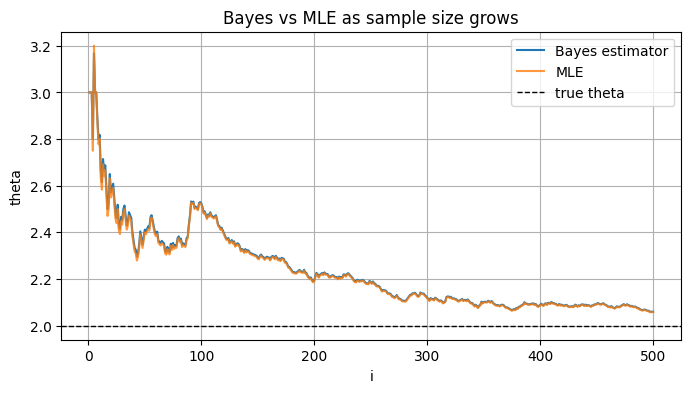

In [35]:
# (i) Compare Bayes and MLE trajectories
plt.plot(idx, bayes_est, label="Bayes estimator")
plt.plot(idx, mle, label="MLE", alpha=0.8)
plt.axhline(true_theta, color="black", linestyle="--", linewidth=1, label="true theta")
plt.title("Bayes vs MLE as sample size grows")
plt.xlabel("i")
plt.ylabel("theta")
plt.legend()
plt.show()

**Discussion.** The Bayes estimator is pulled toward the prior mean for small $i$, while the MLE depends only on the data. As $i$ grows, both estimators stabilize and converge near the true value. The credible intervals (Bayes) and asymptotic confidence intervals (MLE) both narrow with $i$, but the Bayes intervals tend to be slightly tighter early on due to the prior information.